# Performance notes

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import pylandstats as pls

This notebook will serve to compare the performance of PyLandStats with those of FRAGSTATS (v4.2) [1] and [the R package landscapemetrics](https://github.com/r-spatialecology/landscapemetrics) (v1.0) [2]. As a benchmark, we will compute [all the metrics implemented in PyLandStats](https://pylandstats.readthedocs.io/en/latest/landscape.html#list-of-implemented-metrics) (note however that landscapemetrics only computes the mean, standard deviation and coefficient of variation of each patch metric, whereas PyLandStats and FRAGSTATS further compute the area-weighted mean, median and range of each patch metric).

All the execution times discussed in this notebook have been obtained in an Ubuntu desktop computer with the following processor:

```bash
$ cat /proc/cpuinfo  | grep 'name'| uniq
model name : Intel(R) Xeon(R) CPU E5-1620 0 @ 3.60GHz
```

The execution times for the FRAGSTATS software have been obtained by manually selecting the metrics in the graphical user interface (run in Ubuntu by means of the [WineHQ](https://wiki.winehq.org/Ubuntu) compatibility layer for Windows applications).

On the other hand, the execution times for the landscapemetrics package have been obtained by running [a dedicated R script](https://github.com/martibosch/pylandstats-notebooks/tree/master/other/metricsBenchmark.R) in a Docker instance of the image [`rocker/geospatial`](https://hub.docker.com/r/rocker/geospatial/). Note that such Docker image does not include the landscapemetrics package out of the box, but it can be easily installed as in `install.packages("landscapemetrics")`.

## Benchmarks

Let us first define a function to make a very simple benchmark plot:

In [ ]:
def benchmark_plot(execution_times):
    x = np.arange(3)
    plt.bar(x, execution_times)
    plt.xticks(x, ["FRAGSTATS", "landscapemetrics", "PyLandStats"])

### Benchmark 1: Canton of Vaud

We will first measure the execution times for the extract of the Canton of Vaud (Switerland) derived from the [CORINE Land Cover dataset](https://land.copernicus.eu/pan-european/corine-land-cover) of the year 2000, reclassified into urban and non-urban classes.

In [ ]:
ls = pls.Landscape("../data/raw/clc/vaud_g100_clc00_V18_5.tif", res=(100, 100))

print(
    f"Landscape size [pixels]: {ls.landscape_arr.shape[0]}x"
    f"{ls.landscape_arr.shape[1]}"
)
print(f"Number of classes: {len(ls.classes)}")

Landscape size [pixels]: 889x916
Number of classes: 2


In [ ]:
%%time
patch_df = ls.compute_patch_metrics_df()
class_df = ls.compute_class_metrics_df()
landscape_df = ls.compute_class_metrics_df()

CPU times: user 965 ms, sys: 3.69 ms, total: 969 ms
Wall time: 972 ms


The execution times for this first benchmark are of 610 ms with FRAGSTATS and 14.27 s with landscapemetrics. In the same computer, the execution time of the above cell is of 969 ms, which gives us the following plot:

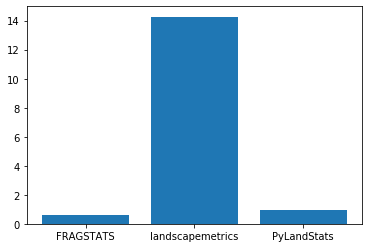

In [ ]:
benchmark_plot([0.61, 14.27, 0.969])

### Benchmark 2: Cantons of Bern and Valais

We will now measure the execution times for an extract of the cantons of Bern and Valais (Switzerland), also derived from the CORINE Land Cover dataset of the year 2000, however, this time without reclassifying the land cover classes.

In [ ]:
ls = pls.Landscape("../data/raw/clc/bern_valais_g100_clc00.tif", res=(100, 100))

print(
    f"Landscape size [pixels]: {ls.landscape_arr.shape[0]}x"
    f"{ls.landscape_arr.shape[1]}"
)
print(f"Number of classes: {len(ls.classes)}")

Landscape size [pixels]: 1640x1319
Number of classes: 28


In [ ]:
%%time
patch_df = ls.compute_patch_metrics_df()
class_df = ls.compute_class_metrics_df()
landscape_df = ls.compute_class_metrics_df()

/home/martibosch/libraries/pylandstats/pylandstats/landscape.py:789: RuntimeWarning: Class 10 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  RuntimeWarning)
/home/martibosch/libraries/pylandstats/pylandstats/landscape.py:803: RuntimeWarning: Class 10 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  RuntimeWarning)
/home/martibosch/anaconda3/envs/pylandstats/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


CPU times: user 32.9 s, sys: 16.8 ms, total: 32.9 s
Wall time: 32.9 s


The execution times for this second benchmark are of 33.31 s with FRAGSTATS and 553.45 s (i.e., 9 min 13 s) with landscapemetrics. In the same computer, the execution time of the above cell is of 32.9 s, which gives us the following plot:

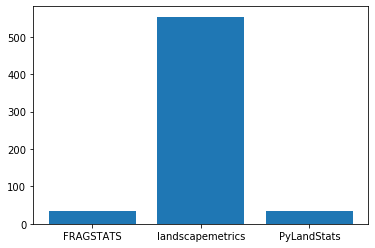

In [ ]:
benchmark_plot([33.31, 553.45, 32.9])

## PyLandStats performance and implementation details

In PyLandStats, each landscape is a Python object, upon which Python properties are employed to cache results that are computationally expensive to obtain and can later be accessed in constant (almost immediate) time. This mechanism is exploited to cache intermediate results that are later used to compute the metrics. More precisely, instances of the Landscape class cache the list of patches, each with its respective LULC class, area, perimeter and nearest-neigbhor distance, as well as the pixel adjacency matrix, i.e., the number of adjacencies between pixels of each landscape class (including adjacencies between pixels of the same class).

To illustrate such mechanism, let us re-instantiate the landscape for the Cantons of Bern and Valais:

In [ ]:
ls = pls.Landscape("../data/raw/clc/bern_valais_g100_clc00.tif", res=(100, 100))

Right after the instantiation of a landscape object, none of the attributes listed below are defined:

In [ ]:
print(hasattr(ls, "_cached_num_patches_dict"))
print(hasattr(ls, "_cached_patch_area_ser"))
print(hasattr(ls, "_cached_patch_perimeter_ser"))

False
False
False


Nevertheless, after computing an area-related, e.g., `area`:

In [ ]:
%%time
area = ls.area()

CPU times: user 765 ms, sys: 0 ns, total: 765 ms
Wall time: 769 ms


the Python properties defined in the `Landscape` class will set the `_cached_num_patches_dict` (number of patches of each LULC class) and `_cached_patch_area_ser` (area of each patch) attributes, which can hereafter be accessed in constant (almost immediate) time:

In [ ]:
ls._cached_num_patches_dict

{1: 7,
 2: 427,
 3: 52,
 4: 2,
 6: 11,
 7: 8,
 9: 2,
 10: 1,
 11: 14,
 12: 191,
 15: 31,
 16: 11,
 18: 473,
 20: 84,
 21: 39,
 23: 89,
 24: 533,
 25: 579,
 26: 329,
 27: 209,
 29: 72,
 30: 19,
 31: 218,
 32: 490,
 34: 151,
 35: 6,
 40: 8,
 41: 31}

In [ ]:
ls._cached_patch_area_ser.head()

0     590000
1     950000
2     710000
3    1110000
4     500000
Name: area, dtype: int64

Similarly, after computing a perimeter-related metric, e.g., `perimeter_area_ratio`, the attribute `_cached_patch_perimeter_ser` (perimeter of each patch) will be set, and hereafter accessible in constant time:

In [ ]:
%%time
perimeter = ls.perimeter()

CPU times: user 928 ms, sys: 0 ns, total: 928 ms
Wall time: 931 ms


In [ ]:
ls._cached_patch_perimeter_ser.head()

0    5200
1    5200
2    6000
3    8600
4    4800
Name: perimeter, dtype: int64

Note that after the area and perimeter of each patch are cached, the computation of other area, edge and shape metrics is orders of magnitude faster

In [ ]:
%%time
frac = ls.fractal_dimension()

CPU times: user 0 ns, sys: 3.13 ms, total: 3.13 ms
Wall time: 2.35 ms


And the same applies to the computations that require the class adjacency matrix

In [ ]:
hasattr(ls, "_cached_adjacency_df")

False

In [ ]:
%%time
ed = ls.edge_density()

CPU times: user 138 ms, sys: 39 µs, total: 138 ms
Wall time: 137 ms


In [ ]:
ls._cached_adjacency_df.head()

1.0    2.0    3.0    4.0    6.0    7.0    9.0    10.0   \
direction  class_val                                                           
horizontal 1.0          818    140     13     10      0      0      0      0   
           2.0          140  72852    520     28     23      2      0     22   
           3.0           13    520   4598      5      4      0      3      2   
           4.0           10     28      5     98      0      0      0      0   
           6.0            0     23      4      0   1322      0      0      0   

                      11.0   12.0   ...  27.0   29.0   30.0   31.0   32.0   \
direction  class_val                ...                                      
horizontal 1.0            0      0  ...      0      0      0      0      0   
           2.0          102   6583  ...     30      4      1      4     21   
           3.0           36    356  ...      2      0      0      0      0   
           4.0            0      0  ...      0      0      0      0      0   
           6.0            0     77  ...      0      0      0      0      0   

                      34.0   35.0   40.0   41.0   255.0  
direction  class_val                                     
horizontal 1.0            0      0      0      0      0  
           2.0            0     13     72    295    119  
           3.0            0      0      1      7      8  
           4.0            0      0      0      0      0  
           6.0            0      0      0      0      0  

[5 rows x 29 columns]

In [ ]:
%%time
lsi = ls.landscape_shape_index()

CPU times: user 8.11 ms, sys: 2 µs, total: 8.12 ms
Wall time: 7.31 ms


But it is when it comes to the computation of the inter-patch nearest-neighbor distances (the most computationally expensive task) that performance gains become more significant:

In [ ]:
hasattr(ls, "_cached_patch_euclidean_nearest_neighbor_ser")

False

In [ ]:
%%time
enn = ls.euclidean_nearest_neighbor()

CPU times: user 26.5 s, sys: 7.73 ms, total: 26.6 s
Wall time: 26.6 s


In [ ]:
ls._cached_patch_euclidean_nearest_neighbor_ser.head()

0    23584.952830
1      360.555128
2      316.227766
3      316.227766
4    18112.150618
Name: euclidean_nearest_neighbor, dtype: float64

In [ ]:
%%time
enn_l_sd = ls.euclidean_nearest_neighbor_sd()

CPU times: user 4.48 ms, sys: 5 µs, total: 4.49 ms
Wall time: 3.54 ms


Note that the first computation of the euclidean nearest-neighbor takes 26.6 s out of the total 32.9 s required to compute all the metrics, making it by far the main performance bottleneck of PyLandStats. It is therefore recommended that in analysis cases that do not require computing euclidean nearest-neighbor metrics avoid its computation by making use of the `metrics` keyword argument of the `compute_patch_metrics_df`, `compute_class_metrics_df` and `compute_landscape_metrics_df` methods.

## References

1. Kevin McGarigal, Sam A Cushman, and Eduard Ene. Fragstats v4: spatial pattern analysis program for categorical and continuous maps. Computer software program produced by the authors at the University of Massachusetts, Amherst. Available at: http://www.umass.edu/landeco/research/fragstats/fragstats.html, 2012.
2. Maximilian HK Hesselbarth, Marco Sciaini, Kimberly A With, Kerstin Wiegand, and Jakub Nowosad. landscapemetrics: an open-source r tool to calculate landscape metrics. Ecography, 2019.